In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import dynsys_reservoir as dynsys
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import PRA as pra
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
np.random.seed(42)  # For reproducibility

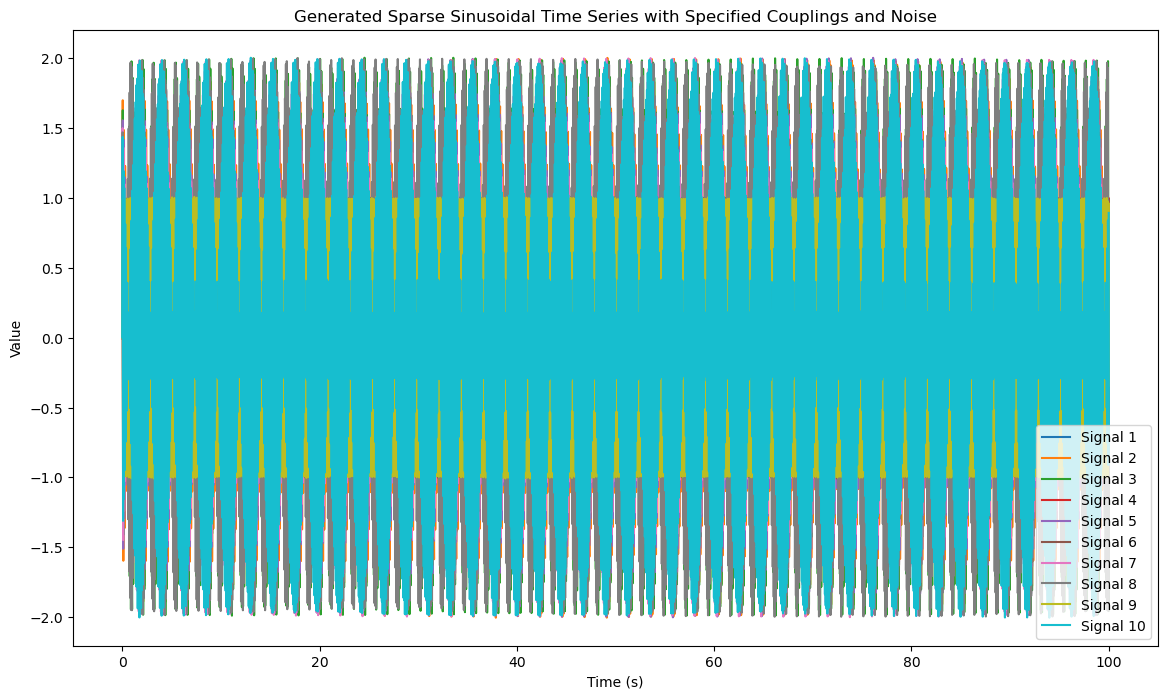

In [2]:


# Parameters
sampling_rate = 100  # Hz
duration = 100  # seconds
n_points = sampling_rate * duration
time = np.linspace(0, duration, n_points)

# Generate base sine waves for each signal within the alpha band
base_freqs = np.linspace(8, 12, 10)  # 10 signals with frequencies from 8Hz to 12Hz
signals = [np.sin(2 * np.pi * f * time) for f in base_freqs]

# Coupling strengths and lag
coupling_strengths = np.ones(10) #np.random.rand(10)  # Random strengths for variety
lag = 2 # Time steps lag

# Apply specific sparse connections
signals[1][lag:] += coupling_strengths[0] * signals[0][:-lag]  # 1 influences 2
signals[2][lag:] += coupling_strengths[1] * signals[0][:-lag]  # 1 influences 3
signals[4][lag:] += coupling_strengths[3] * signals[3][:-lag]  # 4 influences 5
signals[6][lag:] += coupling_strengths[5] * signals[5][:-lag]  # 6 influences 7
signals[7][lag:] += coupling_strengths[5] * signals[5][:-lag]  # 6 influences 8
signals[9][lag:] += coupling_strengths[8] * signals[8][:-lag]  # 9 influences 10

# Add noise
noise_level = 0.003
signals = [s + noise_level * np.random.randn(n_points) for s in signals]

# Plot the time series
plt.figure(figsize=(14, 8))
for i, s in enumerate(signals):
    plt.plot(time, s, label=f'Signal {i+1}')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title('Generated Sparse Sinusoidal Time Series with Specified Couplings and Noise')
plt.show()


In [3]:
"""# Parameters
sampling_rate = 100  # Hz
duration = 100  # seconds
n_points = sampling_rate * duration
time = np.linspace(0, duration, n_points)

# Base frequencies for the sine waves
freq_A = 8.7  # Hz
freq_B = 10.1  # Hz
freq_C = 11.4   # Hz

# Generate base sine waves
A = np.sin(2 * np.pi * freq_A * time)
B = np.sin(2 * np.pi * freq_B * time)
C = np.sin(2 * np.pi * freq_C * time)

# Coupling strengths
coupling_strengths = [1,1,1]  # A->B, A->C coupling strengths

# Introduce coupling with lag
for t in range(3, n_points):
    B[t] += coupling_strengths[0] * A[t-2]  # A influences B
    C[t] += coupling_strengths[1] * A[t-2]  # A influences C
    #A[t] += coupling_strengths[2]  # C influences A

# Add noise
noise_level = 0.003
A += noise_level * np.random.randn(n_points)
B += noise_level * np.random.randn(n_points)
C += noise_level * np.random.randn(n_points)


# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(time, A, label='Time Series A')  # Plot a subset for clearer visualization
plt.plot(time, B, label='Time Series B')
#plt.plot(time, C, label='Time Series C')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title('Generated Sinusoidal Time Series with Recurrent Coupling and Noise')
plt.show()"""

"# Parameters\nsampling_rate = 100  # Hz\nduration = 100  # seconds\nn_points = sampling_rate * duration\ntime = np.linspace(0, duration, n_points)\n\n# Base frequencies for the sine waves\nfreq_A = 8.7  # Hz\nfreq_B = 10.1  # Hz\nfreq_C = 11.4   # Hz\n\n# Generate base sine waves\nA = np.sin(2 * np.pi * freq_A * time)\nB = np.sin(2 * np.pi * freq_B * time)\nC = np.sin(2 * np.pi * freq_C * time)\n\n# Coupling strengths\ncoupling_strengths = [1,1,1]  # A->B, A->C coupling strengths\n\n# Introduce coupling with lag\nfor t in range(3, n_points):\n    B[t] += coupling_strengths[0] * A[t-2]  # A influences B\n    C[t] += coupling_strengths[1] * A[t-2]  # A influences C\n    #A[t] += coupling_strengths[2]  # C influences A\n\n# Add noise\nnoise_level = 0.003\nA += noise_level * np.random.randn(n_points)\nB += noise_level * np.random.randn(n_points)\nC += noise_level * np.random.randn(n_points)\n\n\n# Plot the time series\nplt.figure(figsize=(14, 6))\nplt.plot(time, A, label='Time Series A') 

In [4]:
## simulated data
#sim_data = np.array([A,B,C])
sim_data = np.array(signals)
info = mne.create_info(ch_names=["A", "B", "C","D","E","F","G","H","I","J"], ch_types=["eeg"]*10, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=20)

Creating RawArray with float64 data, n_channels=10, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


In [5]:
## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['A','B','C']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)

#PRA
pra_mat = pra.PRA(epochs.get_data())


#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sampling_rate, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sampling_rate, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

Using data from preloaded Raw for 5 events and 2000 original time points ...
0 bad epochs dropped


  0%|          | 0/5 [00:00<?, ?it/s]

Using data from preloaded Raw for 5 events and 2000 original time points ...


  0%|          | 0/5 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 45 connections
    using t=0.000s..19.990s for estimation (2000 points)
    frequencies: 8.0Hz..13.0Hz (101 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 45 connections
    using t=0.000s..19.990s for estimation (2000 points)
    frequencies: 8.0Hz..13.0Hz (101 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: 

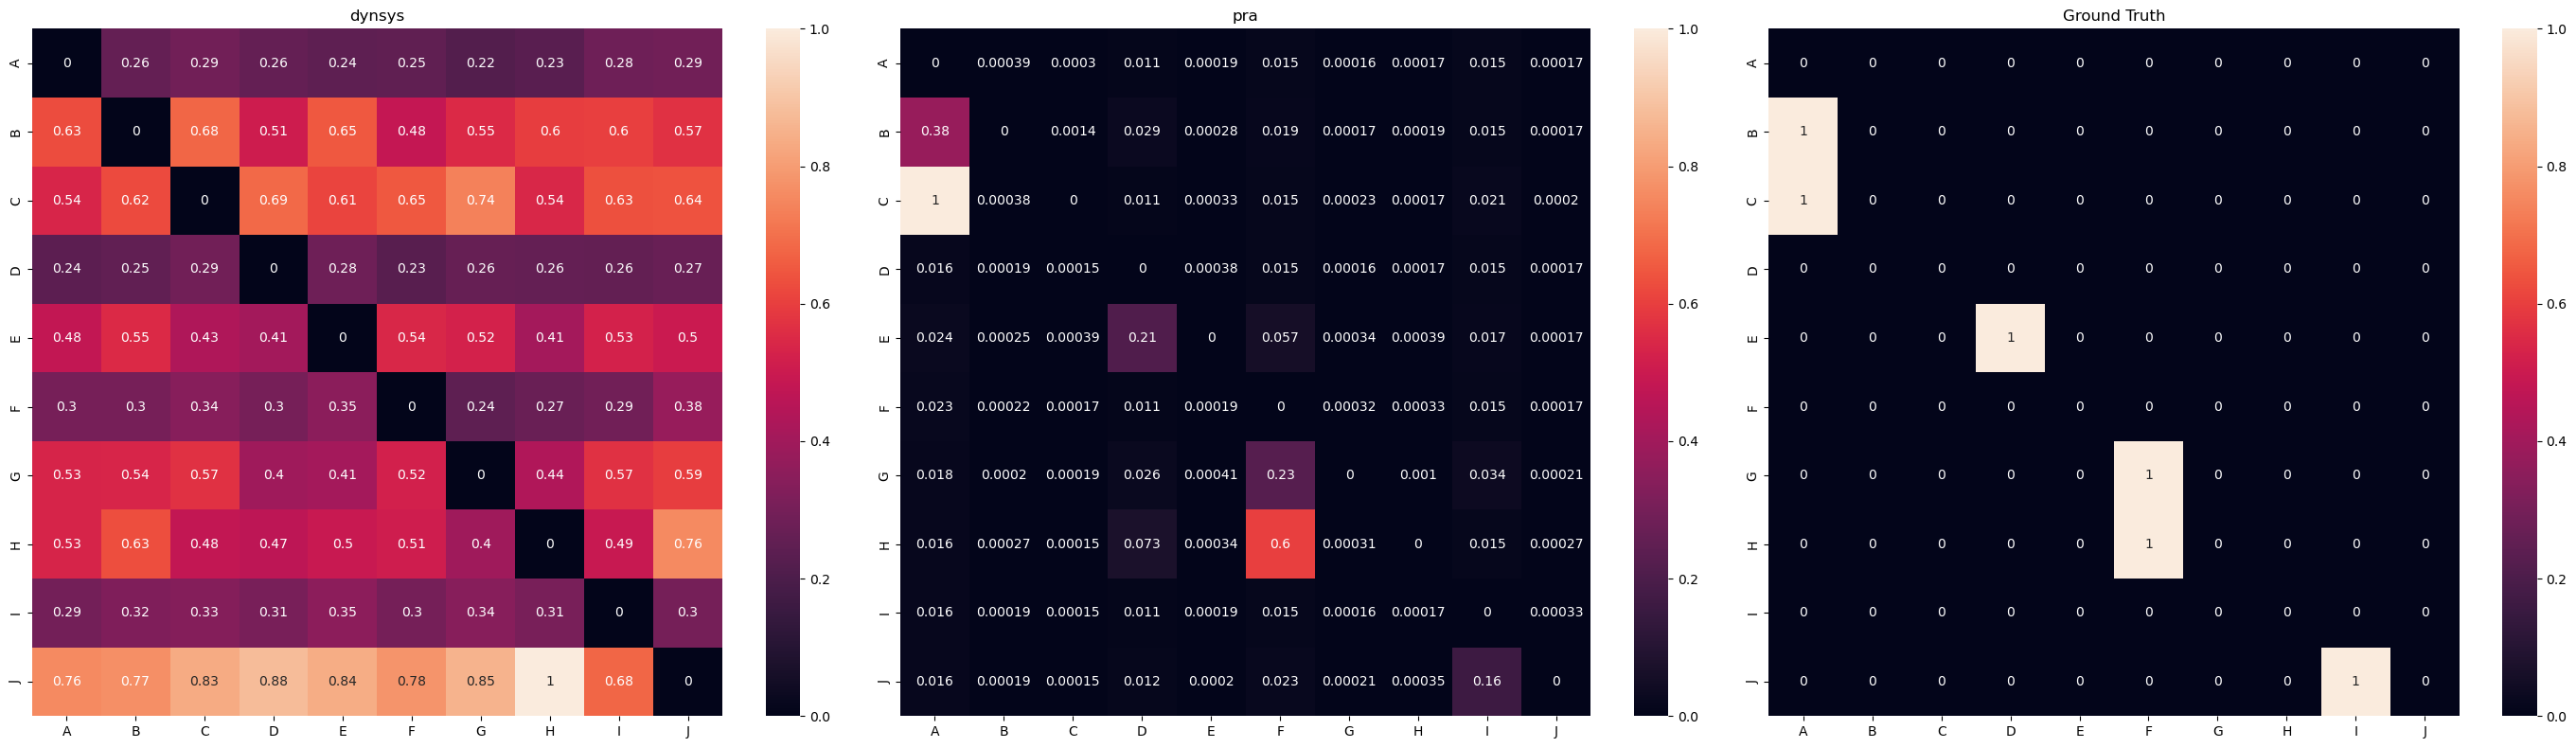

In [31]:
# Create the ground truth connectivity matrix as a NumPy array
ground_truth = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]).T

labels = ['A','B','C','D','E','F','G','H','I','J']

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(28,8))
sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['A','B','C','D','E','F','G','H','I','J'], yticklabels=['A','B','C','D','E','F','G','H','I','J'], ax=ax1)
ax1.set_title('dynsys')

sns.heatmap(pra_mat, annot=True, xticklabels=['A','B','C','D','E','F','G','H','I','J'], yticklabels=['A','B','C','D','E','F','G','H','I','J'], ax=ax2)
ax2.set_title('pra')

# Plotting the ground truth connectivity matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(ground_truth, annot=True, xticklabels=['A','B','C','D','E','F','G','H','I','J'], yticklabels=['A','B','C','D','E','F','G','H','I','J'], ax=ax3)
ax3.set_title('Ground Truth')

fig.tight_layout()
plt.show()


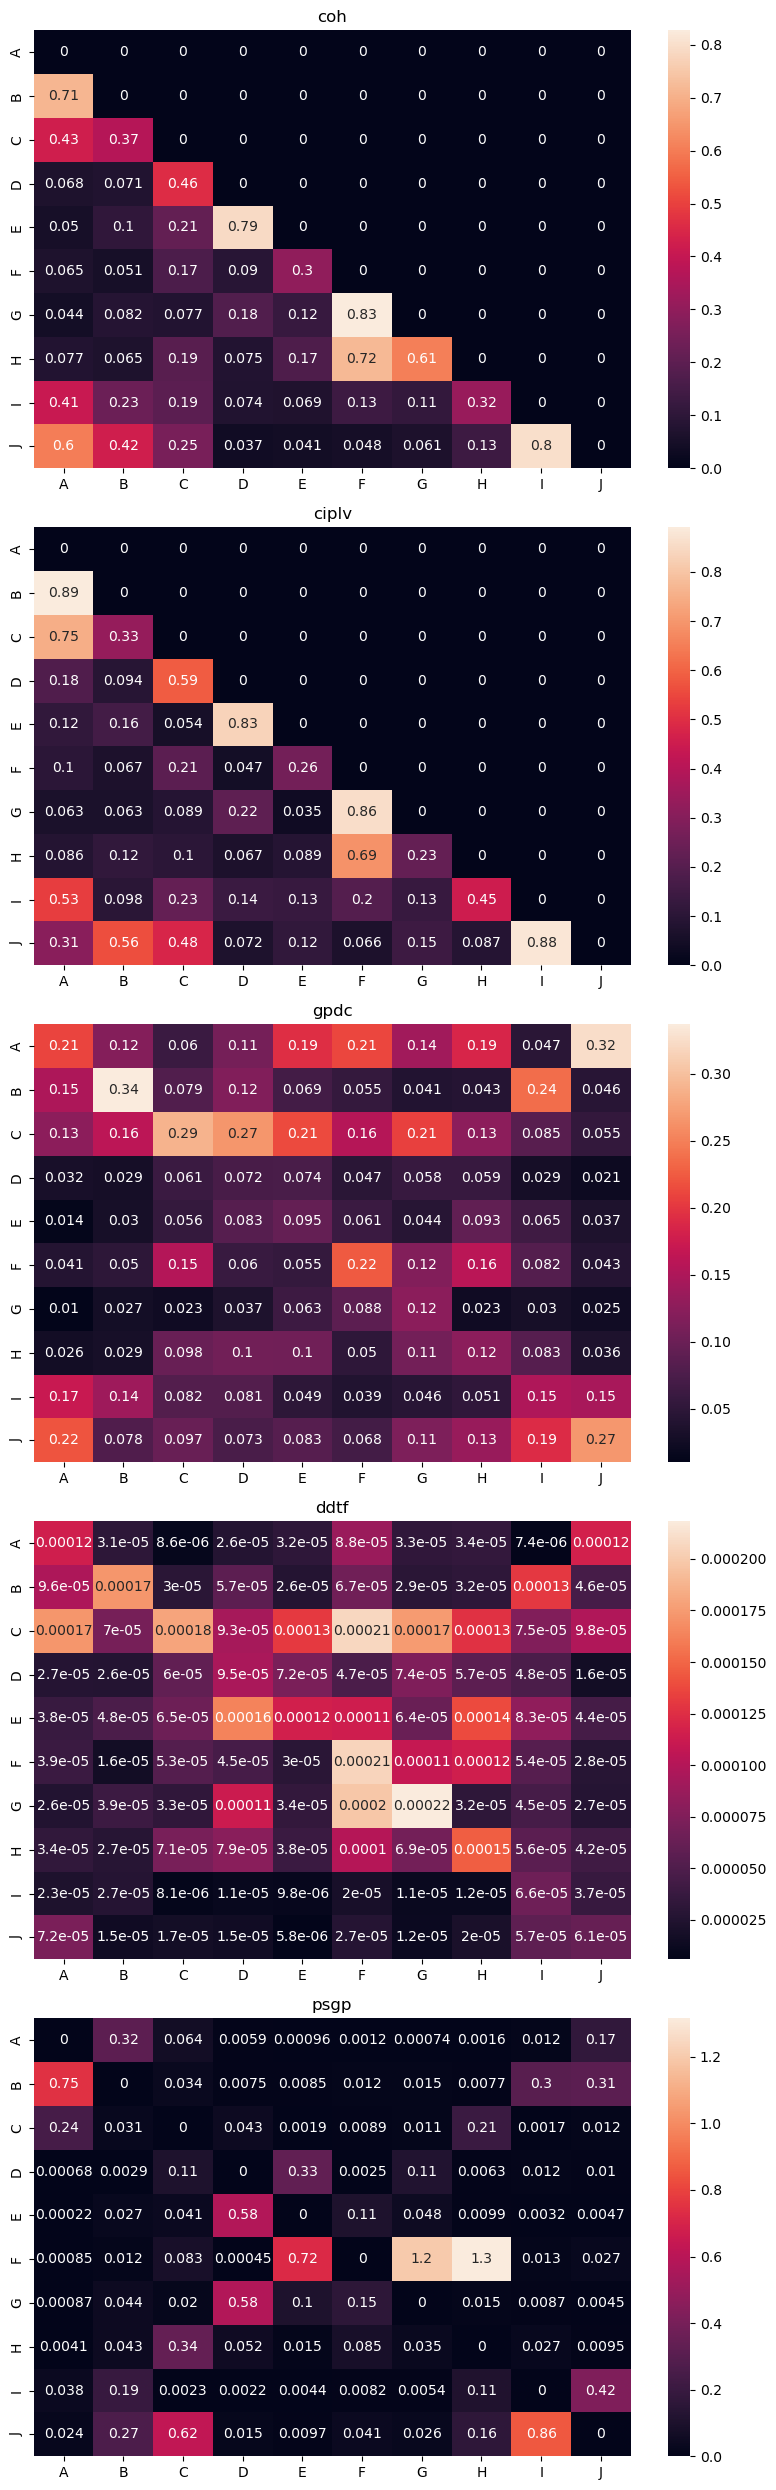

In [32]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(8,25))
sns.heatmap(coh_mat.mean(2), annot=True, xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat.mean(2), annot=True, xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat.mean(2), annot=True, xticklabels=labels, yticklabels=labels, ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat.mean(2), annot=True, xticklabels=labels, yticklabels=labels, ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat.mean(2), annot=True, xticklabels=labels, yticklabels=labels, ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.show()